In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

In [37]:
def plot_confusion_matrix(model, X, y):
    y_pred = (model.predict(X)).argmax(axis=-1)
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', alpha=0.8, vmin=0)

In [38]:
data = pd.read_csv("./data/Q3/train.csv")
data.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [39]:

data.drop(['customer_id', 'Name','security_no', 'referral_id','last_visit_time'], inplace=True, axis=1)

In [40]:
data.drop(data[data.churn_risk_score == -1].index, inplace=True)
data.describe()
data.shape

(35829, 20)

In [41]:
data['region_category'].fillna('other', inplace=True)
data['points_in_wallet'].fillna(0, inplace=True)
data['preferred_offer_types'].fillna(data['preferred_offer_types'].mode()[0], inplace=True)


In [42]:
data['joining_date'] = pd.to_datetime(data['joining_date'])
data['days_since_joined'] = data['joining_date'].apply(lambda x:(pd.Timestamp('today') - x).days)
data.drop(['joining_date'], inplace=True, axis=1)


In [43]:
data['days_since_last_login'] = data["days_since_last_login"].apply(lambda x : x if x >= 0 else 20)

In [44]:
data['avg_time_spent'] = data["avg_time_spent"].apply(lambda x : x if x >= 0 else 0)

In [45]:
data['avg_frequency_login_days'] = data["avg_frequency_login_days"].apply(lambda x : x if x != 'Error' else 0)

data['avg_frequency_login_days'] = pd.to_numeric(data['avg_frequency_login_days'])

In [46]:
# profile = pp.ProfileReport(data)
# profile.to_notebook_iframe()

In [47]:
# plt.rcParams['figure.figsize']=[10,10]
# sns.heatmap(data.corr(),annot=True)

In [48]:
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [49]:
Y_ready = data.pop('churn_risk_score')

In [50]:
numerical_data, categorical_data  = divideFeatures(data)

In [51]:
categorical_data_dummies=pd.get_dummies(categorical_data,drop_first=True)

In [52]:
scaler = preprocessing.StandardScaler()

numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical_data),columns = numerical_data.columns)


In [53]:
numerical_data_scaled.reset_index(drop=True, inplace=True)
categorical_data_dummies.reset_index(drop=True, inplace=True)

In [54]:
X_ready = pd.concat([numerical_data_scaled, categorical_data_dummies], axis=1)


In [55]:
print(X_ready.shape)
print(numerical_data_scaled.shape)
print(categorical_data_dummies.shape)

(35829, 41)
(35829, 7)
(35829, 34)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_ready, Y_ready, train_size=0.8, random_state=1)

In [57]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, input_shape=(41,), activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))

model.add(keras.layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

fit = model.fit(X_train, y_train, epochs=40 )

model.evaluate(X_train, y_train)

Epoch 1/40
896/896 [==============================] - 5s 4ms/step - loss: 0.8453 - accuracy: 0.5698
Epoch 2/40
896/896 [==============================] - 3s 4ms/step - loss: 0.5485 - accuracy: 0.6858
Epoch 3/40
896/896 [==============================] - 3s 4ms/step - loss: 0.4399 - accuracy: 0.7553
Epoch 4/40
896/896 [==============================] - 3s 4ms/step - loss: 0.3846 - accuracy: 0.7826
Epoch 5/40
896/896 [==============================] - 3s 4ms/step - loss: 0.3786 - accuracy: 0.7826
Epoch 6/40
896/896 [==============================] - 3s 4ms/step - loss: 0.3715 - accuracy: 0.7879
Epoch 7/40
896/896 [==============================] - 3s 4ms/step - loss: 0.3617 - accuracy: 0.7930
Epoch 8/40
896/896 [==============================] - 4s 4ms/step - loss: 0.3631 - accuracy: 0.7927
Epoch 9/40
896/896 [==============================] - 5s 6ms/step - loss: 0.3568 - accuracy: 0.7990
Epoch 10/40
896/896 [==============================] - 5s 6ms/step - loss: 0.3552 - accuracy: 0.7968

[0.12033627927303314, 0.9477723836898804]

In [61]:
pred = model.predict(X_test).argmax(axis=-1)

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       0.71      0.71      0.71       546
           2       0.69      0.70      0.70       519
           3       0.92      0.90      0.91      2169
           4       0.62      0.67      0.65      1908
           5       0.76      0.73      0.75      2024

    accuracy                           0.76      7166
   macro avg       0.74      0.74      0.74      7166
weighted avg       0.76      0.76      0.76      7166



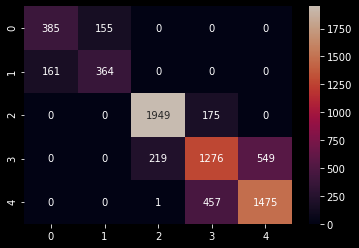

In [58]:
plot_confusion_matrix(model, X_test, y_test)

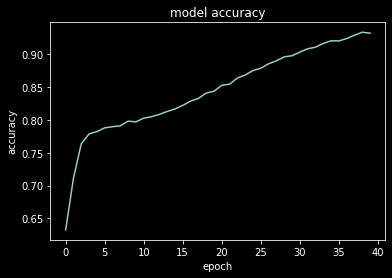

In [59]:
plt.plot(fit.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [60]:
from sklearn.svm import SVC
svm = SVC(C=2, kernel='rbf', gamma='auto', verbose=True)
svm.fit(X_train, y_train)

[LibSVM]

SVC(C=2, gamma='auto', verbose=True)

In [62]:
accuracy = svm.score(X_test, y_test)
accuracy

0.6868545911247558